In [93]:
import pandas as pd
import researchpy as py
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

#####KEEP CATEGORY OF INTEREST IN POS 0

cat = ['IncomeDisposable','CommunitySupport']

def readcsv(name, cat_Type, *categories):
    df = pd.read_csv(name)


    df = df.replace(r'^\s*$', np.nan, regex=True)

    for category in categories:
        df[category] = df[category].astype(cat_Type)
        
    return df

df =readcsv('2020Data.csv',float,cat)

wlbh13 =  df[cat[0]].dropna()
wlbl13 = df[cat[1]].dropna()


def percentiles(dfz,percentile,label,cat_v ,percentile_cat):
    
    percentile_label = []
    cat_Var = []

    for i in percentile:#can add bins here, for now not necessary but will allow cuts into more percentiles
         percentile_label.append(np.nanpercentile(dfz[percentile_cat],i))
            
    dfz[cat_v] = pd.cut(dfz[percentile_cat],
                             bins = [percentile_label[0],percentile_label[1],percentile_label[2],
                                     percentile_label[3],float('Inf')],
                             labels =label, precision = 4 )
#         print(category[z])
    cat_Var.append(dfz[percentile_cat].dropna())
#         print(z)

    print(percentile_label)
    return dfz,cat_Var

df,cat_Var = percentiles(df,[0,25,50,75],[0,1,2,3],'wlblP',cat[1])

# print(df['wlblP'])
# print(df[cat[0]])

new_df = df[[cat[0],cat[1],'wlblP']]
new_df = new_df.dropna()

ANOVA =stats.f_oneway(new_df[cat[0]][new_df['wlblP']==0],
              new_df[cat[0]][new_df['wlblP']==1],
              new_df[cat[0]][new_df['wlblP']==2],
              new_df[cat[0]][new_df['wlblP']==3],)



print(df['wlblP'].dropna())
print(wlbh13)
print(ANOVA)
##p val less than alpha, significant result, wlbl and wlbh have significant difference

[78.0, 88.0, 91.0, 93.0]
0     3
1     2
2     1
3     1
4     2
5     0
6     1
7     1
8     3
9     2
10    3
11    1
12    1
13    0
14    0
15    3
16    3
17    0
18    2
19    1
21    0
22    0
23    2
24    0
25    1
26    3
27    3
28    0
29    0
30    1
31    1
32    2
33    0
34    2
35    1
36    2
37    0
38    3
39    1
Name: wlblP, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]
0     32759.0
1     33541.0
2     30364.0
4     30854.0
7     21453.0
8     29606.0
9     19697.0
10    29943.0
11    31304.0
12    34294.0
13    17700.0
16    25310.0
18    26588.0
19    29798.0
20    21882.0
21    16275.0
22    21660.0
23    39264.0
25    29333.0
27    35725.0
28    19814.0
29    21203.0
31    20474.0
32    20820.0
34    23999.0
35    31287.0
36    37466.0
38    28715.0
39    45284.0
Name: IncomeDisposable, dtype: float64
F_onewayResult(statistic=4.223379747737431, pvalue=0.01563539924589172)


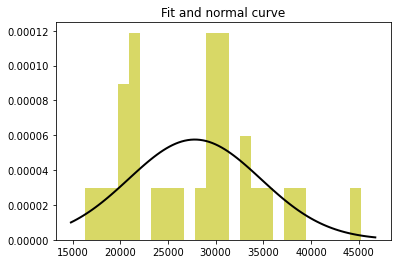

In [90]:
mu,std = stats.norm.fit(wlbh13)

plt.hist(wlbh13, bins=25, density = True, alpha=0.6, color = 'y')
xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = stats.norm.pdf(x,mu,std)
plt.plot(x,p,'k',linewidth = 2)
title = "Fit Disposable income and normal curve"
plt.title(title)
plt.show()

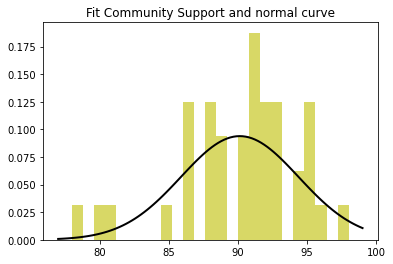

In [96]:
mu,std = stats.norm.fit(wlbl13)

plt.hist(wlbl13, bins=25, density = True, alpha=0.6, color = 'y')
xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = stats.norm.pdf(x,mu,std)
plt.plot(x,p,'k',linewidth = 2)
title = "Fit Community Support and normal curve"
plt.title(title)
plt.show()

In [94]:
stats.levene(df[cat[0]][df['wlblP']==0].dropna(),
              df[cat[0]][df['wlblP']==1].dropna(),
              df[cat[0]][df['wlblP']==2].dropna(),
              df[cat[0]][df['wlblP']==3].dropna(),center = 'mean')

##from levene test samples have diff variances, also obv by looking at norm plot and box plot


LeveneResult(statistic=1.877064368488373, pvalue=0.16042730308243047)

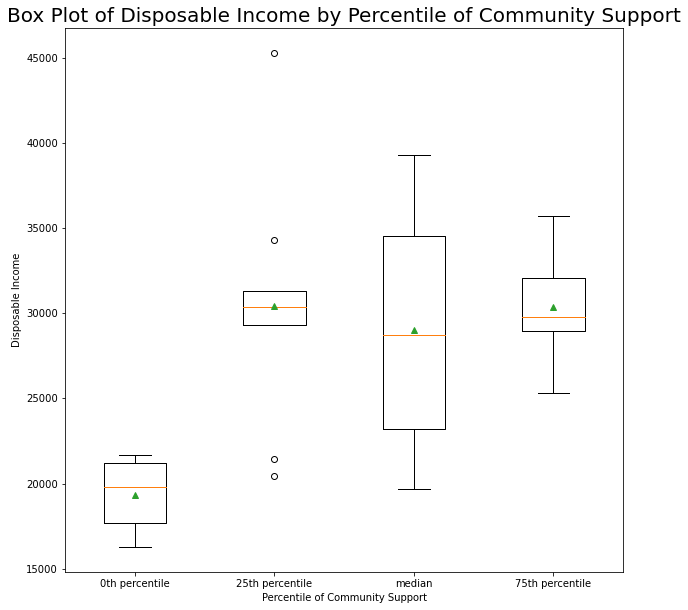

In [97]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Disposable Income by Percentile of Community Support", fontsize= 20)
ax.set

data = [df[cat[0]][df['wlblP']==0].dropna(),
              df[cat[0]][df['wlblP']==1].dropna(),
              df[cat[0]][df['wlblP']==2].dropna(),
              df[cat[0]][df['wlblP']==3].dropna()]

ax.boxplot(data,
           labels= ['0th percentile', '25th percentile', 'median','75th percentile'],
           showmeans= True)

plt.xlabel("Percentile of Community Support")
plt.ylabel("Disposable Income")

plt.show()

In [95]:
from collections import namedtuple
def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = stats.f.sf(dfbn, dfwn, f)
    return F_onewayResult(f, prob)

welch_anova_np(new_df[cat[0]][new_df['wlblP']==0],
              new_df[cat[0]][new_df['wlblP']==1],
              new_df[cat[0]][new_df['wlblP']==2],
              new_df[cat[0]][new_df['wlblP']==3])

F_onewayResult(statistic=15.209828955137391, pvalue=0.021749654302881557)

In [89]:
from scikit_posthocs import posthoc_dunn

g1 = df[cat[0]].dropna()
g2 = df[cat[1]].dropna()
g3 = df['wlblP'].dropna()

data = [g1,g2,g3]

posthoc_dunn(data)

,1,2,3
1,1.000000e+00,6.049585e-06,4.765971e-22
2,6.049585e-06,1.000000e+00,1.971889e-08
3,4.765971e-22,1.971889e-08,1.000000e+00
